# Turbulence Development Over Complex Terrain
This notebook contains the necessary code to analyze the SOWFA simulations that are used to determine the effectiveness of terrain in generating turbulence.

## Import necessary libraries

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sowfadict as sowfa
import tools
from scipy.stats import norm
from scipy.stats import skew,kurtosis
from scipy import signal
import pandas as pd
from matplotlib.colors import Normalize

### Declare user variables (cases, towers, colors, etc.) for tower data

In [43]:
terrstr = 'D2'
caselbl = ['Turb.','Laminar','Pert.']
cases   = ['M2_{}_TurbBC'.format(terrstr),'M2_{}_NoTurbBC'.format(terrstr),'M2_{}_PertBC'.format(terrstr)]
if terrstr == 'SR':
    casec   = ['navy','darkturquoise','blue']
    terrstr_f = 'Complex Terrain'
elif terrstr == 'D2':
    casec   = ['red','goldenrod','darkred']
    terrstr_f = 'Smoothed Terrain'

casece  = [casec[0],'none',casec[2]]#,'none']
casecf  = ['none',casec[1],'none']#,casec[3]]
casem   = ['o','o','d','d']
caselw  = ['3','2','3','2']
casea   = [0.8,1.0,0.8,1.0]
casesz  = [50,15,50,15]
casels  = ['-',':','--']
ncases  = np.shape(cases)[0]

#simstr  = ['PGx2.2En4_zi550','PGx2.2En4_zi550','PGx2.2En4_zi550']#,'PGx2.2En4_zi550']
simstr  = ['PGx2.2En4_zi550']*3
x = np.arange(0,101)

varns   = ['u','v','w','T','uA']
nvars   = np.shape(varns)[0]

timedir = 14400

avgstart = 1799 # when do you want to start the averaging?
avgend   = -1 # when do you want to end the averaging?

lvl     = 5

twrs    = [1,3,5,7]
ntwrs   = np.shape(twrs)[0]

lblsize = 14.0
txtsize = 12.0
legsize = 10.0
savedir = '/home/phawbeck/SOWFA/Terrain/img/'


### Load in the data and store for manipulation & plotting

In [44]:
initIndividualTowerVars = True
initAvgTowerVars        = True
for cc in range(0,ncases):
    for tt in range(0,ntwrs):
        fdir      = '/projects/mmc/NWTCRegion/{}/NWTC.run.{}/postProcessing/'.format(simstr[cc],cases[cc])
        pl        = 'probeLine%d' % twrs[tt]
        probeLine = sowfa.probeLine('%s%s/%d/' % (fdir,pl,timedir),'y',['U','T','UAvg'])
        dt        = np.round(np.mean(probeLine.time[1:] - probeLine.time[:-1]),2)
        ntwr      = probeLine.ntowers; ntwrsq = int(np.sqrt(ntwr))
        if tt == 0: 
            tdz        = np.mean(probeLine.z[0,1:] - probeLine.z[0,:-1]) 
            twrheight  = probeLine.z[0,:] - probeLine.z[0,0] + tdz/2.0
            nz = np.shape(twrheight)[0]
        for vv in range(0,nvars):
            var = varns[vv]
            for tw in np.arange(0,probeLine.ntowers):
                if var == 'u':
                    pvar   = probeLine.u[tw,:,avgstart:avgend]
                    #avgvar = np.mean(probeLine.u[tw,:,avgstart:avgend],axis=1)
                elif var == 'v':
                    pvar   = probeLine.v[tw,:,avgstart:avgend]
                    #avgvar = np.mean(probeLine.v[tw,:,avgstart:avgend],axis=1)
                elif var == 'w':
                    pvar   = probeLine.w[tw,:,avgstart:avgend]
                    #avgvar = np.mean(probeLine.w[tw,:,avgstart:avgend],axis=1)
                elif var == 'T':
                    pvar   = probeLine.T[tw,:,avgstart:avgend]
                    #avgvar = np.mean(probeLine.T[tw,:,avgstart:avgend],axis=1)
                elif var == 'uA':
                    pvar   = probeLine.uAvg[tw,:,avgstart:avgend]
                if initIndividualTowerVars == True:
                    print ("initializing individual tower vars")
                    time       = probeLine.time[avgstart:avgend] 
                    ntimes     = np.shape(time)[0]
                    tsvarfull  = np.zeros((nvars,ncases,ntwrs,ntwr,nz,ntimes))
                    initIndividualTowerVars = False
                tsvarfull[vv,cc,tt,tw,:,:]  = pvar
    print ('Done with case: {}'.format(cases[cc]))

initializing individual tower vars
Done with case: M2_D2_TurbBC
Done with case: M2_D2_NoTurbBC
Done with case: M2_D2_PertBC


### Time series plots

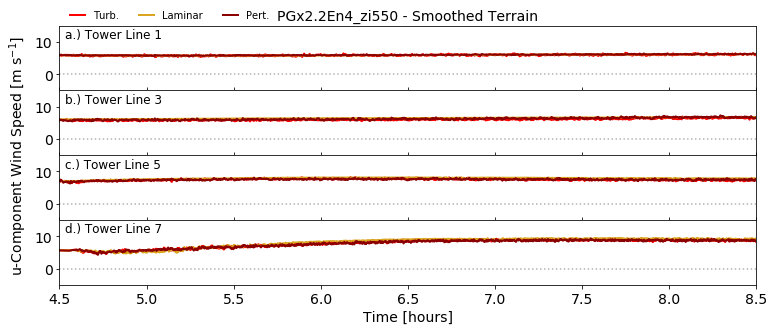

In [45]:
saveFig = True
lvl = 5
var = 'u'
varind = varns.index(var)
specfig = plt.figure(figsize=(11,4.5))
plt.subplots_adjust(left=0.08,right=0.96,bottom=0.13,top=0.93,hspace=0.0)
if var == 'u':
    ybot = -5; ytop = 15
elif var == 'v':
    ybot = -7; ytop = 7
elif var == 'w':
    ybot = -7; ytop = 7
if var == 'T':
    ybot = 299.9; ytop = 300.1
    pltstr = 'Potential Temperature [K]'
else:
    pltstr = '{}-Component Wind Speed [m s$^{{-1}}$]'.format(var)
legloc = (0.01,1.02)

plt1 = plt.subplot2grid((ntwrs,1),(0,0),rowspan=1)
plt2 = plt.subplot2grid((ntwrs,1),(1,0),rowspan=1,sharex=plt1)
plt3 = plt.subplot2grid((ntwrs,1),(2,0),rowspan=1,sharex=plt1)
plt4 = plt.subplot2grid((ntwrs,1),(3,0),rowspan=1,sharex=plt1)

plt1.axhline(0.0,c='k',ls=':',alpha=0.3)
plt2.axhline(0.0,c='k',ls=':',alpha=0.3)
plt3.axhline(0.0,c='k',ls=':',alpha=0.3)
plt4.axhline(0.0,c='k',ls=':',alpha=0.3)
ptime = time / 3600.0
ytics = [1e-2,1e-1,1e0,1e1,1e2,1e3,1e4,1e5,1e6,1e7]
xtics = np.arange(np.min(ptime),np.max(ptime)+0.1,0.5)
txtx = 6e-5
for cc in range(0,ncases):
#    for tt in range(0,ntwrs):
#        pmax = np.amax(tsvarfull[varind,cc,tt,:,lvl,:],axis = 0)
#        pmin = np.amin(tsvarfull[varind,cc,tt,:,lvl,:],axis = 0)
#        if tt == 0: plt1.fill_between(ptime,pmin,pmax,alpha=0.5,edgecolor=casec[cc],linewidth=1.0,facecolor=None)
#        if tt == 1: plt2.fill_between(ptime,pmin,pmax,alpha=0.5,edgecolor=casec[cc],linewidth=1.0,facecolor=None)
#        if tt == 2: plt3.fill_between(ptime,pmin,pmax,alpha=0.5,edgecolor=casec[cc],linewidth=1.0,facecolor=None)
#        if tt == 3: plt4.fill_between(ptime,pmin,pmax,alpha=0.5,edgecolor=casec[cc],linewidth=1.0,facecolor=None)
    for tt in range(0,ntwrs):
        pavg = np.mean(tsvarfull[varind,cc,tt,:,lvl,:],axis = 0)
        if tt == 0: plt1.plot(ptime,pavg,color=casec[cc],linewidth=2.0,label=caselbl[cc])
        if tt == 1: plt2.plot(ptime,pavg,color=casec[cc],linewidth=2.0)
        if tt == 2: plt3.plot(ptime,pavg,color=casec[cc],linewidth=2.0)
        if tt == 3: plt4.plot(ptime,pavg,color=casec[cc],linewidth=2.0,label=caselbl[cc])

            
plt.xlim(np.min(ptime),np.max(ptime))

plt1.set_ylim((ybot,ytop))
plt2.set_ylim((ybot,ytop))
plt3.set_ylim((ybot,ytop))
plt4.set_ylim((ybot,ytop))

plt1.text(4.53,0.95*ytop,'a.) Tower Line %d' % twrs[0],ha='left',va='top',size=txtsize)
plt2.text(4.53,0.95*ytop,'b.) Tower Line %d' % twrs[1],ha='left',va='top',size=txtsize)
plt3.text(4.53,0.95*ytop,'c.) Tower Line %d' % twrs[2],ha='left',va='top',size=txtsize)
plt4.text(4.53,0.95*ytop,'d.) Tower Line %d' % twrs[3],ha='left',va='top',size=txtsize)
plt1.tick_params(axis='x',direction='in',labelbottom=False)
plt2.tick_params(axis='x',direction='in',labelbottom=False)
plt3.tick_params(axis='x',direction='in',labelbottom=False)
plt4.tick_params(axis='x',direction='out')
plt1.tick_params(labelsize=lblsize)
plt2.tick_params(labelsize=lblsize)
plt3.tick_params(labelsize=lblsize)
plt4.tick_params(labelsize=lblsize)
#plt4.set_xticks(xtics)
plt3.text(4.2,ytop,'{}'.format(pltstr),rotation=90,size=lblsize,va='center')
plt4.set_xlabel('Time [hours]',size=lblsize)
plt1.set_title('{} - {}'.format(simstr[0],terrstr_f),size=lblsize)
plt1.legend(frameon=False,loc=legloc,fontsize=legsize,ncol=3,handlelength=1.5)
if saveFig: 
    plt.savefig('{}{}_{}_TimeSeries_{}{}m.pdf'.format(savedir,simstr[0].replace('.','p'),
                                                      terrstr,var,int(twrheight[lvl])))
plt.show()

### Calculate Spectra

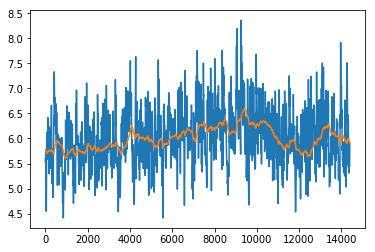

In [46]:
plt.plot(tsvarfull[0,0,0,0,5,:])
plt.plot(tsvarfull[4,0,0,0,5,:])

In [47]:
spec_lvl = 5 # 5 = 110 m; 25 = 510 m
initAvgTowerVars = True
for cc in range(0,ncases):
    for tt in range(0,ntwrs):        
        for vv in range(0,nvars):
            for tw in np.arange(0,probeLine.ntowers):
                #ff,pwr_spec = tools.spectra1d(tsvarfull[vv,cc,tt,tw,spec_lvl,:],dt)
                if vv == 0: 
                    spec_var = tsvarfull[vv,cc,tt,tw,spec_lvl,:] - tsvarfull[4,cc,tt,tw,spec_lvl,:]
                else:
                    spec_var = tsvarfull[vv,cc,tt,tw,spec_lvl,:]
                ff,pwr_spec = signal.welch(spec_var, dt, window='hamm',nperseg=ntimes/4.0, 
                                           scaling='density',detrend='linear')
                if initAvgTowerVars == True:
                    avg_pwr_spec     = np.zeros((nvars,ncases,ntwrs,np.shape(pwr_spec)[0]))
                    initAvgTowerVars = False
                if tw == 0:
                    tot_pwr_spec  = pwr_spec
                else:
                    tot_pwr_spec += pwr_spec
            avg_pwr_spec[vv,cc,tt,:] = tot_pwr_spec/probeLine.ntowers

### Spectra plots
Calculate the spectra of the time series at various tower locations and plot the average along the tower-lines for each case

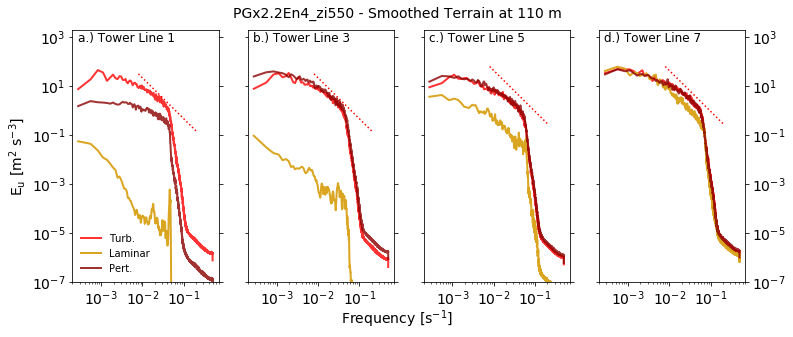

In [48]:
saveFig  = True
var = 'u'
varind = varns.index(var)
specfig = plt.figure(figsize=(11,4.5))
plt.subplots_adjust(left=0.09,right=0.94,bottom=0.15,top=0.93,wspace=0.20)
if var == 'u':
    ybot = 1e-7; ytop = 2e3
elif var == 'w':
    ybot = 1e-2; ytop = 1e4
    
xmin,xmax = 2e-4, 7e-1
ytics = [1e-2,1e-1,1e0,1e1,1e2,1e3,1e4,1e5,1e6,1e7]
xtics = [1e-3,1e-2,1e-1]
txtx = 2e-4
plt1 = plt.subplot2grid((1,ntwrs),(0,0),rowspan=1)
plt2 = plt.subplot2grid((1,ntwrs),(0,1),rowspan=1,sharey=plt1)
plt3 = plt.subplot2grid((1,ntwrs),(0,2),rowspan=1,sharey=plt1)
plt4 = plt.subplot2grid((1,ntwrs),(0,3),rowspan=1,sharey=plt1)
plt1.tick_params(which='both',labelsize=lblsize,right=True,left=True)
plt2.tick_params(which='both',labelsize=lblsize,right=True,left=True,labelleft=False)
plt3.tick_params(which='both',labelsize=lblsize,right=True,left=True,labelleft=False)
plt4.tick_params(which='both',labelsize=lblsize,right=True,left=True,labelleft=False,labelright=True)

plt1.set_ylabel('E$_\mathrm{%s}$ [m$^2$ s$^{-3}$]' % var,size=lblsize)

plt3.set_xticks(xtics)

plt1.set_ylim((ybot,ytop))
plt2.set_ylim((ybot,ytop))
plt3.set_ylim((ybot,ytop))
plt4.set_ylim((ybot,ytop))

plt1.set_xlim((xmin,xmax))
plt2.set_xlim((xmin,xmax))
plt3.set_xlim((xmin,xmax))
plt4.set_xlim((xmin,xmax))

xtxt = xmin + (xmax-xmin)*1e-4
plt1.text(xtxt,0.8*ytop,'a.) Tower Line %d' % twrs[0],ha='left',va='top',size=txtsize)
plt2.text(xtxt,0.8*ytop,'b.) Tower Line %d' % twrs[1],ha='left',va='top',size=txtsize)
plt3.text(xtxt,0.8*ytop,'c.) Tower Line %d' % twrs[2],ha='left',va='top',size=txtsize)
plt4.text(xtxt,0.8*ytop,'d.) Tower Line %d' % twrs[3],ha='left',va='top',size=txtsize)
ref_range = np.asarray([8e-3,2e-1])
for cc in range(0,ncases):
    for tt in range(0,ntwrs):
        krefx = np.arange(0.01,0.201,0.1)
        kshftA = 6.0*ybot*1e2
        kshftB = 5.0*ybot*1e3
        if tt == 0: 
                    plt1.loglog(ff,avg_pwr_spec[varind,cc,tt,:],c=casec[cc],alpha=casea[cc],nonposx='mask',
                                label=caselbl[cc],lw=2.0)
        if tt == 1: plt2.loglog(ff,avg_pwr_spec[varind,cc,tt,:],c=casec[cc],alpha=casea[cc],nonposx='mask',lw=2.0)
        if tt == 2: plt3.loglog(ff,avg_pwr_spec[varind,cc,tt,:],c=casec[cc],alpha=casea[cc],nonposx='mask',lw=2.0)
        if tt == 3: plt4.loglog(ff,avg_pwr_spec[varind,cc,tt,:],c=casec[cc],alpha=casea[cc],nonposx='mask',
                                label=caselbl[cc],lw=2.0)

plt1.plot(ref_range,1e-2*ref_range**(-5/3),c='r',ls=':')
plt2.plot(ref_range,1e-2*ref_range**(-5/3),c='r',ls=':')
plt3.plot(ref_range,2e-2*ref_range**(-5/3),c='r',ls=':')
plt4.plot(ref_range,2e-2*ref_range**(-5/3),c='r',ls=':')
plt.text(0.5, 1.0, '{} - {} at {} m'.format(simstr[cc],terrstr_f,int(twrheight[spec_lvl])),ha='center', va='top',
         transform=specfig.transFigure,size=lblsize)
plt.text(0.5, 0.07, 'Frequency [s$^{-1}$]',ha='center', va='top',transform=specfig.transFigure,size=lblsize)
plt1.legend(frameon=False,loc=3,fontsize=legsize)
if saveFig: 
    plt.savefig('{}{}_{}_Spectra_{}{}m.pdf'.format(savedir,simstr[cc].replace('.','p'),
                                                           terrstr,var,int(twrheight[spec_lvl])))
plt.show(specfig)

### Calculate ordered data for PDF

In [ ]:
initIndividualTowerVars = True
initAvgTowerVars        = True
for cc in range(0,ncases):
    for tt in range(0,ntwrs):
        for vv in range(0,nvars):
            for tw in np.arange(0,probeLine.ntowers):
                varp = np.sort(tsvarfull[vv,cc,tt,tw,lvl,:] - np.mean(tsvarfull[vv,cc,tt,tw,lvl,:]))
                if tw == 0:
                    varpf = varp
                else:
                    varpf = np.append(varpf,varp)
            if initAvgTowerVars == True: 
                varpfull    = np.zeros((nvars,ncases,ntwrs,np.shape(varpf)[0]))
                initAvgTowerVars = False
            varpfull[vv,cc,tt,:]    = np.sort(varpf)

### PDF of the time series
Plot the probability distribution/density functions for each case. PSD are calculated for all towers along given tower-lines.

In [ ]:
saveFig = True
var = 'u'
varind = varns.index(var)
pdffig = plt.figure(figsize=(11,4.5))
plt.subplots_adjust(left=0.09,right=0.94,bottom=0.13,top=0.91,wspace=0.28)

plt1 = plt.subplot2grid((1,ntwrs),(0,0),rowspan=1)
plt2 = plt.subplot2grid((1,ntwrs),(0,1),rowspan=1)
plt3 = plt.subplot2grid((1,ntwrs),(0,2),rowspan=1)
plt4 = plt.subplot2grid((1,ntwrs),(0,3),rowspan=1)
plt1.set_yscale('log')
plt2.set_yscale('log')
plt3.set_yscale('log')
plt4.set_yscale('log')

plt1.tick_params(right=True,left=True,labelsize=lblsize)
plt2.tick_params(right=True,left=True,labelsize=lblsize,labelleft=False)
plt3.tick_params(right=True,left=True,labelsize=lblsize,labelleft=False)
plt4.tick_params(right=True,left=True,labelsize=lblsize,labelleft=False,labelright=True)

plt1.set_ylabel('PDF [%]',size=lblsize)
plt1.set_xlim(-10,10)
plt2.set_xlim(-10,10)
plt3.set_xlim(-10,10)
plt4.set_xlim(-10,10)
ybot = 1e-13; ytop = 2e1
plt1.set_ylim(ybot,ytop)
plt2.set_ylim(ybot,ytop)
plt3.set_ylim(ybot,ytop)
plt4.set_ylim(ybot,ytop)
plt2.text(12,ybot*0.01,"%s' [m s$^{-1}$]" % var,ha='center',va='center',size=lblsize)

plt1.text(-9,0.65*ytop,'a.) Tower Line %d' % twrs[0],ha='left',va='top',size=txtsize)
plt2.text(-9,0.65*ytop,'b.) Tower Line %d' % twrs[1],ha='left',va='top',size=txtsize)
plt3.text(-9,0.65*ytop,'c.) Tower Line %d' % twrs[2],ha='left',va='top',size=txtsize)
plt4.text(-9,0.65*ytop,'d.) Tower Line %d' % twrs[3],ha='left',va='top',size=txtsize)

for cc in range(0,ncases):
    for tt in range(0,ntwrs):
        if tt == 0: 
            plt1.scatter(varpfull[varind,cc,tt,:],norm.pdf(varpfull[varind,cc,tt,:]),
                         edgecolors=casece[cc],lw=2.0,alpha=casea[cc],facecolors=casecf[cc],
                         s=casesz[cc],marker=casem[cc],label=caselbl[cc])
        if tt == 1: 
            plt2.scatter(varpfull[varind,cc,tt,:],norm.pdf(varpfull[varind,cc,tt,:]),
                         edgecolors=casece[cc],lw=2.0,alpha=casea[cc],facecolors=casecf[cc],
                         s=casesz[cc],marker=casem[cc])
        if tt == 2: 
            plt3.scatter(varpfull[varind,cc,tt,:],norm.pdf(varpfull[varind,cc,tt,:]),
                         edgecolors=casece[cc],lw=2.0,alpha=casea[cc],facecolors=casecf[cc],
                         s=casesz[cc],marker=casem[cc])
        if tt == 3: 
            plt4.scatter(varpfull[varind,cc,tt,:],norm.pdf(varpfull[varind,cc,tt,:]),
                         edgecolors=casece[cc],lw=2.0,alpha=casea[cc],facecolors=casecf[cc],
                         s=casesz[cc],marker=casem[cc])
#plt.suptitle("Probability Density Function of %s' at %3.1f m" % (var,twrheight[lvl]), size=lblsize)
plt.suptitle("%s Terrain: %s\n%s' at %3.1f m" % (simstr[cc],terrstr,var,twrheight[lvl]), y=1.01,size=lblsize)
plt1.legend(frameon=False,loc=8,fontsize=9)
if saveFig: plt.savefig('{}{}_{}_PDF_{}{}m.pdf'.format(savedir,simstr[cc].replace('.','p'),terrstr,var,int(twrheight[lvl])))
plt.show(pdffig)

### Plot average profiles of given variables

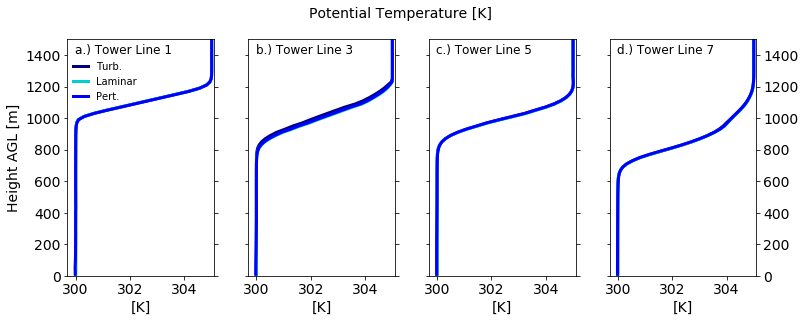

In [21]:
saveFig = True
var = 'T'
varind = varns.index(var)
avgprfplt = plt.figure(figsize=(11,4.5))
plt.subplots_adjust(left=0.08,right=0.95,bottom=0.15,top=0.88,wspace=0.23)

ybot = 0; ytop = 1500
if var == 'u':
    xmin = 0.0; xmax = 15.0 # 18.0
elif var == 'v':
    xmin = -3.0; xmax = 3.0
elif var == 'w':
    xmin = -2.0; xmax = 2.0
elif var == 'T':
    xmin = 299.7; xmax = 305.1
if var == 'T':
    plt.suptitle('Potential Temperature [K]',size=lblsize)
    labelstr = '[K]'
    legloc = 4
else:
    plt.suptitle('{}-component Wind Speed\n{} - {}'.format(var,simstr[0],terrstr_f),size=lblsize)
    labelstr = '[m s$^{-1}$]'
    legloc = (0.01,1.02)

plt1 = plt.subplot2grid((1,ntwrs),(0,0),rowspan=1)
plt2 = plt.subplot2grid((1,ntwrs),(0,1),rowspan=1)
plt3 = plt.subplot2grid((1,ntwrs),(0,2),rowspan=1)
plt4 = plt.subplot2grid((1,ntwrs),(0,3),rowspan=1)

plt1.tick_params(right=True,left=True,labelsize=lblsize)
plt2.tick_params(right=True,left=True,labelsize=lblsize,labelleft=False)
plt3.tick_params(right=True,left=True,labelsize=lblsize,labelleft=False)
plt4.tick_params(right=True,left=True,labelsize=lblsize,labelleft=False,labelright=True)

plt1.set_ylabel('Height AGL [m]',size=lblsize)
plt1.set_xlabel(labelstr,size=lblsize); plt2.set_xlabel(labelstr,size=lblsize)
plt3.set_xlabel(labelstr,size=lblsize); plt4.set_xlabel(labelstr,size=lblsize)

plt1.text(xmin+(xmax-xmin)*0.05,0.98*ytop,'a.) Tower Line %d' % twrs[0],ha='left',va='top',size=txtsize)
plt2.text(xmin+(xmax-xmin)*0.05,0.98*ytop,'b.) Tower Line %d' % twrs[1],ha='left',va='top',size=txtsize)
plt3.text(xmin+(xmax-xmin)*0.05,0.98*ytop,'c.) Tower Line %d' % twrs[2],ha='left',va='top',size=txtsize)
plt4.text(xmin+(xmax-xmin)*0.05,0.98*ytop,'d.) Tower Line %d' % twrs[3],ha='left',va='top',size=txtsize)

pltIndividualLines = False
for cc in range(0,ncases):
    for tt in range(0,ntwrs):
        if pltIndividualLines:
            for tw in np.arange(0,probeLine.ntowers):
                if tt == 0: plt1.plot(np.mean(tsvarfull[varind,cc,tt,tw,:,:],axis=1),
                                      twrheight,c=casec[cc],lw=1.0,alpha=0.3)
                if tt == 1: plt2.plot(np.mean(tsvarfull[varind,cc,tt,tw,:,:],axis=1),
                                      twrheight,c=casec[cc],lw=1.0,alpha=0.3)
                if tt == 2: plt3.plot(np.mean(tsvarfull[varind,cc,tt,tw,:,:],axis=1),
                                      twrheight,c=casec[cc],lw=1.0,alpha=0.3)
                if tt == 3: plt4.plot(np.mean(tsvarfull[varind,cc,tt,tw,:,:],axis=1),
                                      twrheight,c=casec[cc],lw=1.0,alpha=0.3)

        if tt == 0: plt1.plot(np.mean(np.mean(tsvarfull[varind,cc,tt,:,:,:],axis=0),axis=1),
                              twrheight,c=casec[cc],lw=3.0,label=caselbl[cc])
        if tt == 1: plt2.plot(np.mean(np.mean(tsvarfull[varind,cc,tt,:,:,:],axis=0),axis=1),
                              twrheight,c=casec[cc],lw=3.0,label=caselbl[cc])
        if tt == 2: plt3.plot(np.mean(np.mean(tsvarfull[varind,cc,tt,:,:,:],axis=0),axis=1),
                              twrheight,c=casec[cc],lw=3.0,label=caselbl[cc])
        if tt == 3: plt4.plot(np.mean(np.mean(tsvarfull[varind,cc,tt,:,:,:],axis=0),axis=1),
                              twrheight,c=casec[cc],lw=3.0,label=caselbl[cc])

plt1.set_ylim(ybot,ytop)
plt2.set_ylim(ybot,ytop)
plt3.set_ylim(ybot,ytop)
plt4.set_ylim(ybot,ytop)

plt1.set_xlim(xmin,xmax)
plt2.set_xlim(xmin,xmax)
plt3.set_xlim(xmin,xmax)
plt4.set_xlim(xmin,xmax)

#plt1.legend(loc=legloc,frameon=False,fontsize=legsize,handlelength=1.5,ncol=1)
plt1.legend(loc=(0.01,0.72),frameon=False,fontsize=legsize,handlelength=1.5,ncol=1)
if saveFig: plt.savefig('{}{}_{}_AvgProfile_{}.pdf'.format(savedir,simstr[cc].replace('.','p'),terrstr,var))
plt.show(avgprfplt)
